In [1]:
# import numpy as np
import pennylane as qml
from pennylane import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from conv_psr import qconv_psr
from pooling import max_pooling2d
from dense import classic_dense
from dense import classic_dense_psr
from utils import linearizer
from actv import soft_max_1d
from net import PSR_Net
from cost import cross_entropy

### dataset

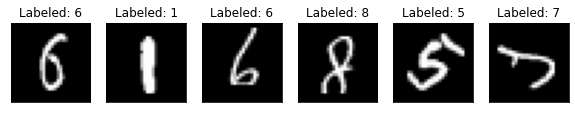

In [2]:
data_root = '/home/hades/Documents/quantum_computing/Qcnn/data/MNIST_original/'
train_root = data_root + 'mnist_train.csv'
test_root = data_root + 'mnist_test.csv'

train_data_df = pd.read_csv(train_root, index_col=0)
test_data_df = pd.read_csv(test_root, index_col=0)

train_data = np.array(train_data_df)
test_data = np.array(test_data_df)

train_lables = np.array(train_data_df.index)
test_lables = np.array(test_data_df.index)

shuffler = np.random.permutation(len(train_data))
train_data =  train_data[shuffler]
train_label = train_lables[shuffler]

train_data = train_data[:200]
train_label = train_label[:200]

n_samples_show = 6

fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images = train_data[n_samples_show].reshape(28,28)
    targets = train_label[n_samples_show]

    axes[n_samples_show - 1].imshow(images, cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

### qernel

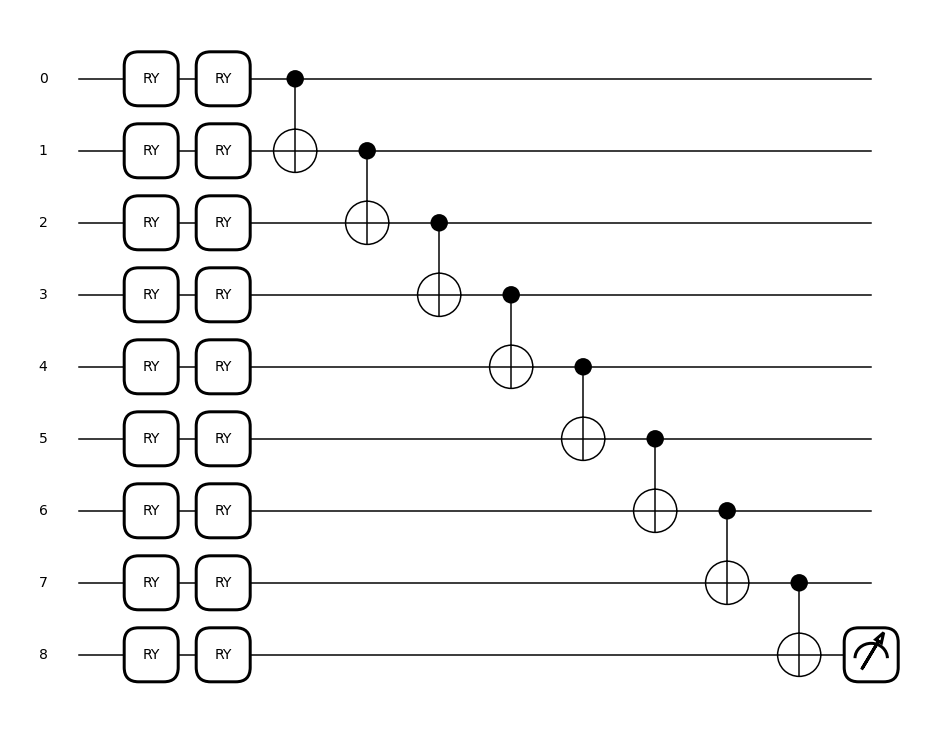

In [3]:
dev = qml.device("lightning.gpu", wires=9)

@qml.qnode(dev)
def Kernel(data, phi):

    qml.RY(data[0], wires=0)
    qml.RY(data[1], wires=1)
    qml.RY(data[2], wires=2)
    qml.RY(data[3], wires=3)
    qml.RY(data[4], wires=4)
    qml.RY(data[5], wires=5)
    qml.RY(data[6], wires=6)
    qml.RY(data[7], wires=7)
    qml.RY(data[8], wires=8)

    qml.RY(phi[0], wires=0)
    qml.RY(phi[1], wires=1)
    qml.RY(phi[2], wires=2)
    qml.RY(phi[3], wires=3)
    qml.RY(phi[4], wires=4)
    qml.RY(phi[5], wires=5)
    qml.RY(phi[6], wires=6)
    qml.RY(phi[7], wires=7)
    qml.RY(phi[8], wires=8)

    qml.CNOT(wires=(0, 1))
    qml.CNOT(wires=(1, 2))
    qml.CNOT(wires=(2, 3))
    qml.CNOT(wires=(3, 4))
    qml.CNOT(wires=(4, 5))
    qml.CNOT(wires=(5, 6))
    qml.CNOT(wires=(6, 7))
    qml.CNOT(wires=(7, 8))

    return qml.expval(qml.PauliZ(8))

np.random.seed(0)
random_trash_data = np.random.rand(9, requires_grad=True)
weights_init = 0.01 * np.random.randn(2, 9, requires_grad=True)

qml.drawer.use_style(style="solarized_dark")
fig, ax = qml.draw_mpl(Kernel)(random_trash_data, weights_init[0])

In [4]:
fqconv = qconv_psr(Kernel, 3, weights_init[0])
sqconv = qconv_psr(Kernel, 3, weights_init[0])
fmp = max_pooling2d()
tqconv = qconv_psr(Kernel, 3, weights_init[0])
# tqconv = qconv_psr(Kernel, 3, weights_init[0])
smp = max_pooling2d()
frs = linearizer()
fcdl = classic_dense_psr(25, 10, np.random.rand(25,10))
fsm = soft_max_1d()

In [5]:
test = PSR_Net([
    fqconv, #0 7
    sqconv, #1 6
    fmp,    #2 5
    tqconv, #3 4
    smp,    #4 3
    frs,    #5 2
    fcdl,   #6 1
    fsm,    #7 0
], cost=cross_entropy)

In [6]:
test.train(train_data[:10].reshape(-1,28,28), train_label[:10], 2)

[0 6 1 6 8]
step:  0
step:  1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  0
step:  1
step:  2
step:  3


/home/hades/drive/conda/envs/pytorch/lib/python3.10/site-packages/pennylane/numpy/tensor.py:154: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/hades/Documents/quantum_computing/Qcnn/kiwi_psr_module/dense.py:109: RuntimeWarning: invalid value encountered in double_scalars
  res = (sum(up_cost)-sum(down_cost))/(2*0.001*len(self.last_label))


step:  4
step:  5
step:  6
step:  7
[5 7 5 2 6]
step:  0
step:  1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  0
step:  1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
